In [0]:
# Setup - copy-pasted from 2A

# Python ≥3.9 is required
import sys
assert sys.version_info >= (3, 9)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np
import pandas as pd

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rc('axes', labelsize=14)
#mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

# Statistical analysis and testing
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Ignore useless warnings (see SciPy issue #5998 and seaborn/matplotlib bug)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", message="The figure layout has changed to tight")

import json

In [1]:
f=open("default-cards-20240806090619.json")
raw_data = json.load(f)
# raw_data[0]

In [2]:
df = pd.DataFrame.from_dict(raw_data)

In [3]:
def expand_dict_features(data: pd.DataFrame) -> pd.DataFrame:
    engineered_data = data.copy()
    legalities_df = pd.DataFrame(engineered_data["legalities"].tolist())
    prices_df = pd.DataFrame(engineered_data["prices"].tolist())
    engineered_data = engineered_data.drop(columns=["legalities","prices"])
    engineered_data = engineered_data.join(legalities_df)
    engineered_data = engineered_data.join(prices_df)
    return engineered_data

In [4]:
def drop_junk_features(data: pd.DataFrame) -> pd.DataFrame:
    junk_columns = [
    # These provide no info - the entire dataset has "card", "en", null, False, and False respectively
    "object",
    "lang",
    "attraction_lights",
    "oversized",
    "variation",

    # Others that need to gtfo:
    "games",


    # Various IDs
    "oracle_id", 
    "arena_id", 
    "multiverse_ids", 
    "tcgplayer_id", 
    "cardmarket_id",
    "artist_ids",
    "illustration_id", 
    "tcgplayer_etched_id",
    "mtgo_foil_id",
    "collector_number",
    "set_id",


    # Various URIs 
    "uri", 
    "scryfall_uri", 
    "image_status",
    "image_uris",
    "set_name",
    "set_uri",
    "set_search_uri",
    "scryfall_set_uri",
    "rulings_uri",
    "prints_search_uri",
    "related_uris",
    "purchase_uris",
    "card_back_id",


    # Random text-based stuff the algo won't understand
    "oracle_text",
    "flavor_text",
    "artist",
    "preview",

    "all_parts",
    "promo_types",
    "finishes",

    # Misc other stuff irrelevant to data analysis
    "highres_image", 


    # Stuff with <1000 non-null
    "card_faces",
    "loyalty",          # Tempted to keep this one, but I'll be consistent for now
    "printed_name",
    "flavor_name",
    "color_indicator",
    "printed_type_line",
    "printed_text",
    "variation_of",
    "life_modifier",
    "hand_modifier",
    "content_warning",

    "security_stamp",
    "watermark",
    "frame_effects",

    # These ones are <1000, but they are also just bools, so I'll let these ones go

    #"textless",
    #"full_art",       # Also kinda wanna break the rules on this one

    #"reserved",     # VERY tempted here
    #"story_spotlight",


    "set", # Useless to the algorithm - it can get what it needs from card age + set_type

    # Prices other than tix (I don't want the program to have these)
    "usd",
    "usd_foil",
    "usd_etched",
    "eur",
    "eur_foil",
    

    # Arena-specific format legalities (irrelevant to MTGO)
    "brawl",
    "historic",
    "standardbrawl",
    "alchemy",
    "explorer", 
    "gladiator",
    "timeless",

    # Other format legalities that no one gives a shit about
    #"future",
    #"paupercommander",
    #"duel",
    #"oldschool",
    #"premodern",
    #"predh",

    # 
]
    engineered_data = data.copy()
    engineered_data = engineered_data.drop(columns=junk_columns)
    return engineered_data

In [5]:
def clean_dataset(data: pd.DataFrame) -> pd.DataFrame:
    # I want to only keep cards that are relevant to actual play of the game, on MTGO
    # Therefore a) remove any card not on MTGO (eg. alchemy-only cards, Fallout cards etc)
    # ... and also need to remove cards which are on mtgo but inexplicably don't have a tix value stored! 

    # b) remove anything "banned" in Vintage (ie. ante, conspiracy, dexterity, subgame cards)
    # ...actually those cards aren't on MTGO anyway! -> unnecessary
    
    engineered_data = data.copy()
    #engineered_data = engineered_data.dropna()
    engineered_data = engineered_data[engineered_data.tix.notna()]
    engineered_data = engineered_data[engineered_data.vintage != "not_legal"]
    engineered_data = engineered_data[engineered_data.vintage != "banned"]
    #engineered_data = engineered_data[engineered_data.colors.notna()] # Temporary fix, removes all DFCs, replace and impute them at some point
    return engineered_data

# END OF COPY-PASTE

In [6]:
df2 = expand_dict_features(df)
df3 = drop_junk_features(df2)
df4 = clean_dataset(df3)
df4


,id,mtgo_id,name,released_at,layout,mana_cost,cmc,type_line,colors,color_identity,...,vintage,penny,commander,oathbreaker,paupercommander,duel,oldschool,premodern,predh,tix
0,0000419b-0bba-4488-8f7a-6194544ce91e,129825.000,Forest,2024-08-02,normal,,0.000,Basic Land — Forest,[],[G],...,legal,legal,legal,legal,legal,legal,not_legal,legal,legal,0.02
1,0000579f-7b35-4ed3-b44c-db2a538066fe,25527.000,Fury Sliver,2006-10-06,normal,{5}{R},6.000,Creature — Sliver,[R],[R],...,legal,not_legal,legal,legal,restricted,legal,not_legal,not_legal,legal,0.03
2,00006596-1166-4a79-8443-ca9f82e6db4e,34586.000,Kor Outfitter,2009-10-02,normal,{W}{W},2.000,Creature — Kor Soldier,[W],[W],...,legal,legal,legal,legal,legal,legal,not_legal,not_legal,legal,0.03
4,0000cd57-91fe-411f-b798-646e965eec37,65170.000,Siren Lookout,2017-09-29,normal,{2}{U},3.000,Creature — Siren Pirate,[U],[U],...,legal,legal,legal,legal,legal,legal,not_legal,not_legal,not_legal,0.03
7,0001e77a-7fff-49d2-a55c-42f6fdf6db08,116428.000,Obyra's Attendants // Desperate Parry,2023-09-08,adventure,{4}{U} // {1}{U},5.000,Creature — Faerie Wizard // Instant — Adventure,[U],[U],...,legal,not_legal,legal,legal,legal,legal,not_legal,not_legal,not_legal,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97263,fffaa737-ce46-4f35-aa8c-bd9bb77ed9f6,57710.000,Angel's Tomb,2015-07-17,normal,{3},3.000,Artifact,[],[],...,legal,legal,legal,legal,not_legal,legal,not_legal,not_legal,not_legal,0.04
97266,fffc85fb-1a40-4f83-a36e-cec0b7be658a,127441.000,Aggressive Biomancy,2024-06-14,normal,{X}{X}{G}{U},2.000,Sorcery,"[G, U]","[G, U]",...,legal,not_legal,legal,legal,not_legal,legal,not_legal,not_legal,not_legal,0.42
97268,fffce2f7-b619-4483-a75e-916343194641,19591.000,Horned Troll,2003-07-28,normal,{2}{G},3.000,Creature — Troll,[G],[G],...,legal,legal,legal,legal,legal,legal,not_legal,legal,legal,0.03
97269,fffdf7f3-a230-417a-883a-069aabcbcca7,117284.000,Faerie Bladecrafter,2023-09-08,normal,{2}{B},3.000,Creature — Faerie Rogue,[B],[B],...,legal,not_legal,legal,legal,not_legal,legal,not_legal,not_legal,not_legal,2.22


In [7]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46956 entries, 0 to 97270
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               46956 non-null  object 
 1   mtgo_id          46956 non-null  float64
 2   name             46956 non-null  object 
 3   released_at      46956 non-null  object 
 4   layout           46956 non-null  object 
 5   mana_cost        46315 non-null  object 
 6   cmc              46950 non-null  float64
 7   type_line        46950 non-null  object 
 8   colors           46315 non-null  object 
 9   color_identity   46956 non-null  object 
 10  keywords         46956 non-null  object 
 11  produced_mana    6956 non-null   object 
 12  reserved         46956 non-null  bool   
 13  foil             46956 non-null  bool   
 14  nonfoil          46956 non-null  bool   
 15  promo            46956 non-null  bool   
 16  reprint          46956 non-null  bool   
 17  set_type         

In [8]:
df4.sample(5)

,id,mtgo_id,name,released_at,layout,mana_cost,cmc,type_line,colors,color_identity,...,vintage,penny,commander,oathbreaker,paupercommander,duel,oldschool,premodern,predh,tix
31674,5377da39-2152-414f-8b7e-638cb2e127e3,124769.000,Big Score,2024-04-19,normal,{3}{R},4.000,Instant,[R],[R],...,legal,legal,legal,legal,legal,legal,not_legal,not_legal,not_legal,0.05
64166,a8a69f7b-be68-43f7-b1ed-df528bde74e5,23456.000,"Sunhome, Fortress of the Legion",2005-10-07,normal,,0.000,Land,[],"[R, W]",...,legal,not_legal,legal,legal,not_legal,legal,not_legal,not_legal,legal,0.03
77839,cc9b0c14-c50c-4727-aa2a-3eb25892e8c2,97931.000,Invoke the Winds,2022-03-15,normal,{1}{U}{U}{U}{U},5.000,Sorcery,[U],[U],...,legal,legal,legal,legal,not_legal,legal,not_legal,not_legal,not_legal,0.13
37801,63325755-47d5-4bb2-a21c-f324c27e1bbd,114327.000,Exotic Orchard,2023-08-04,normal,,0.000,Land,[],[],...,legal,legal,legal,legal,not_legal,legal,not_legal,not_legal,legal,0.02
84929,df027117-9cb2-428f-b5ab-eb4491493fa3,66199.000,Durkwood Baloth,2017-11-17,normal,{4}{G}{G},6.000,Creature — Beast,[G],[G],...,legal,legal,legal,legal,legal,legal,not_legal,not_legal,legal,0.06


In [9]:
set(df4.set_type)

{'arsenal',
 'box',
 'commander',
 'core',
 'draft_innovation',
 'duel_deck',
 'expansion',
 'from_the_vault',
 'funny',
 'masterpiece',
 'masters',
 'planechase',
 'promo',
 'starter',
 'treasure_chest'}

In [10]:
#housing.sqft_living.hist(bins=100, figsize=(12 ,8))

tix = df4.tix.astype("float64")
tix=tix[tix!=0]
log_tix = np.log10(tix)
tix.describe()
#print(tix)

count   46952.000
mean        0.414
std         3.026
min         0.010
25%         0.030
50%         0.040
75%         0.090
max       490.660
Name: tix, dtype: float64

In [11]:
def convert_variable_to_numbers(data, column_name, data_type):
    engineered_data = data.copy()

    new_column = engineered_data[column_name].astype(data_type)
    engineered_data = engineered_data.drop(columns=column_name).join(new_column)
    return engineered_data


In [12]:
def convert_all_to_numbers(data = pd.DataFrame) -> pd.DataFrame:
    engineered_data = data.copy()

    engineered_data = convert_variable_to_numbers(engineered_data, "tix", "float64")

    bool_vars = ["reserved","foil","nonfoil","promo","reprint","digital",
                 "story_spotlight","full_art","textless","booster"
                ]
                # "standard","future","pioneer","modern","legacy","pauper","vintage",
                # "penny","commander","oathbreaker","paupercommander","duel",
                # "oldschool","premodern","predh"


    
    for column_name in bool_vars:
        engineered_data = convert_variable_to_numbers(engineered_data, column_name, "int")
        

    


    return engineered_data


In [13]:
df5 = convert_all_to_numbers(df4)

In [ ]:
def create_log_tix(data = pd.DataFrame) -> pd.DataFrame:
    engineered_data = data.copy()
    tix_values = engineered_data.tix
    log_tix = np.log(np.add(tix_values,0.005)).astype("float64").rename("log_tix")
    print(log_tix)
    engineered_data = engineered_data.join(log_tix)
    return engineered_data

In [ ]:
df6 = create_log_tix(df5)

0       -3.689
1       -3.352
2       -3.352
4       -3.352
7       -3.352
         ...  
97263   -3.101
97266   -0.856
97268   -3.352
97269    0.800
97270   -3.352
Name: log_tix, Length: 46956, dtype: float64


In [ ]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46956 entries, 0 to 97270
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               46956 non-null  object 
 1   mtgo_id          46956 non-null  float64
 2   name             46956 non-null  object 
 3   released_at      46956 non-null  object 
 4   layout           46956 non-null  object 
 5   mana_cost        46315 non-null  object 
 6   cmc              46950 non-null  float64
 7   type_line        46950 non-null  object 
 8   colors           46315 non-null  object 
 9   color_identity   46956 non-null  object 
 10  keywords         46956 non-null  object 
 11  produced_mana    6956 non-null   object 
 12  set_type         46956 non-null  object 
 13  rarity           46956 non-null  object 
 14  border_color     46956 non-null  object 
 15  frame            46956 non-null  object 
 16  power            22595 non-null  object 
 17  toughness        

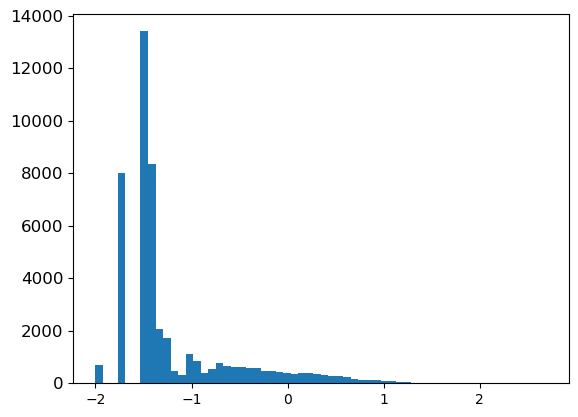

In [ ]:
plt.hist(log_tix, bins=60)
plt.show()

In [18]:
other = df6[df6.rarity=="mythic"]
pd.concat([other, df6[df6.rarity=="special"]])
pd.concat([other, df6[df6.rarity=="bonus"]])

common = df6[df6.rarity=="common"]
uncommon = df6[df6.rarity=="uncommon"]
rare = df6[df6.rarity=="rare"]
mythic = df6[df6.rarity=="mythic"]
bonus = df6[df6.rarity=="bonus"]
special = df6[df6.rarity=="special"]

#other = pd.concat([mythic, bonus, special])

common.info()

plt.plot(np.sort(common.log_tix), color="blue")
plt.plot(np.sort(uncommon.log_tix), color="green")
plt.plot(np.sort(rare.log_tix), color="purple")
plt.plot(np.sort(mythic.log_tix), color="red")
plt.plot(np.sort(special.log_tix), color="orange")
plt.plot(np.sort(bonus.log_tix), color="yellow")

plt.plot(np.sort(other.log_tix), color="black")


plt.legend()
plt.show

<class 'pandas.core.frame.DataFrame'>
Index: 15806 entries, 0 to 97270
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15806 non-null  object 
 1   mtgo_id          15806 non-null  float64
 2   name             15806 non-null  object 
 3   released_at      15806 non-null  object 
 4   layout           15806 non-null  object 
 5   mana_cost        15728 non-null  object 
 6   cmc              15800 non-null  float64
 7   type_line        15800 non-null  object 
 8   colors           15728 non-null  object 
 9   color_identity   15806 non-null  object 
 10  keywords         15806 non-null  object 
 11  produced_mana    3262 non-null   object 
 12  set_type         15806 non-null  object 
 13  rarity           15806 non-null  object 
 14  border_color     15806 non-null  object 
 15  frame            15806 non-null  object 
 16  power            7234 non-null   object 
 17  toughness        

/var/folders/sw/pwx4c2hx5dn8lyy63sj549ch0000gn/T/ipykernel_3666/1903561149.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

In [33]:
df6.columns

Index(['id', 'mtgo_id', 'name', 'released_at', 'layout', 'mana_cost', 'cmc',
       'type_line', 'colors', 'color_identity', 'keywords', 'produced_mana',
       'set_type', 'rarity', 'border_color', 'frame', 'power', 'toughness',
       'edhrec_rank', 'penny_rank', 'standard', 'future', 'pioneer', 'modern',
       'legacy', 'pauper', 'vintage', 'penny', 'commander', 'oathbreaker',
       'paupercommander', 'duel', 'oldschool', 'premodern', 'predh', 'tix',
       'reserved', 'foil', 'nonfoil', 'promo', 'reprint', 'digital',
       'story_spotlight', 'full_art', 'textless', 'booster', 'log_tix'],
      dtype='object')

In [19]:
rarities = [common, uncommon, rare, mythic, special, bonus]

for i in rarities:
    print(np.mean(i.tix))
    print(np.median(i.tix))
    print(len(i))
    print("") 

0.1097051752499051
0.04
15806

0.13219146934295126
0.04
12754

0.726855169584245
0.03
14624

1.4476091415177266
0.25
3413

0.9806857142857143
0.22
350

10.816666666666665
5.47
9



In [20]:
import seaborn as sns

rarities_tix_list = [rarities[i].log_tix for i in range(6)]
rarity_names = ["C","U","R","M","S","B"]

fig, axs = plt.subplots(1,6)

for i in range(6):
    axs[i].boxplot(rarities_tix_list[i])
    axs[i].set_xlabel(rarity_names[i])

In [21]:
p = df6[
    ["edhrec_rank","penny_rank","cmc","reserved","log_tix"]
].plot.box(subplots=True, layout=(3, 3), figsize=(18,18))

In [22]:
plt.scatter(df6["edhrec_rank"],df6["log_tix"], alpha=0.05)

In [23]:
plt.scatter(df6["penny_rank"],df6["log_tix"], alpha=0.1)

In [24]:
plt.scatter(df6["cmc"],df6["log_tix"], alpha=0.02)

In [25]:
#plt.scatter(df6["power"],np.log(df6["tix"]), alpha=0.02)

In [26]:
#plt.scatter(df5["reserved"],np.log(df5["tix"]), alpha=0.005)

In [27]:
#plt.scatter(df5["foil"],np.log(df5["tix"]), alpha=0.01)

In [28]:
def ordinate_rarities(data: pd.DataFrame) -> pd.DataFrame:
    ordinate_rarities_dict = {
        "common": 1, 
        "uncommon": 2,
        "rare": 3, 
        "mythic": 4, 
        "special": 5, 
        "bonus": 5, 
    }
    engineered_data = data.copy()
    ordinate_rarity = [ordinate_rarities_dict[x] for x in engineered_data["rarity"]]
    engineered_data.drop(columns="rarity").join(ordinate_rarity)
    return engineered_data
    #ordinate_rarity = ordinate_rarities_dict[tuple(engineered_data["rarity"][:30])[1]]
    #print(ordinate_rarity)

In [29]:
#df7 = ordinate_rarities(df6)
#df7

In [30]:
corr_matrix = df6.corr(numeric_only=True)
corr_matrix["log_tix"].sort_values(ascending=False)

log_tix            1.000
tix                0.397
mtgo_id            0.234
promo              0.234
digital            0.218
reprint            0.208
reserved           0.078
textless           0.034
full_art           0.027
cmc               -0.032
story_spotlight   -0.045
nonfoil           -0.168
penny_rank        -0.199
foil              -0.218
edhrec_rank       -0.299
booster           -0.451
Name: log_tix, dtype: float64

In [31]:
# Would it be an idea to create a variable of "power / mana value"?

In [32]:
# BIG PLAN: First, finish data preprocessing (UGHHHHHH)
# Then create a baseline model (it'll suck - dataset is highly biased)
# Then downweight low prices (exclude a subset of cards with 0.01 or 0.02 tix from the dataset)